# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [11]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [12]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [13]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

## Define Functions

In [14]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [15]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [16]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [17]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [18]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [19]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

# RANDOM SEED 1

## Prepare Data

In [20]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

# Filter out rows where cat_id is '117A' or '042A' from dataframe
dataframe = dataframe[~dataframe['cat_id'].isin(['117A', '042A'])]

# Filter out rows where cat_id is '117A' or '042A' from augmented_df
augmented_df = augmented_df[~augmented_df['cat_id'].isin(['117A', '042A'])]

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    171
kitten    157
Name: age_group, dtype: int64
adult     588
senior    513
kitten    471
Name: age_group, dtype: int64


In [21]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [22]:
tf.keras.backend.clear_session()

## Run Setup

In [23]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

# Append averages to total lists
all_f1.append(unseen_set_avg_f1)
all_losses.append(unseen_set_avg_loss)
all_accuracies.append(unseen_set_avg_acc)
all_precisions.append(unseen_set_avg_precision)
all_recalls.append(unseen_set_avg_recall)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
002B    32
047A    28
074A    25
        ..
066A     1
091A     1
043A     1
049A     1
090A     1
Name: cat_id, Length: 85, dtype: int64
Testing Set Group Distribution:
103A    33
057A    27
020A    23
101A    15
097B    14
059A    14
001A    14
068A    11
040A    10
005A    10
016A    10
015A     9
072A     9
010A     8
099A     7
053A     6
009A     4
058A     3
060A     3
054A     2
092A     1
048A     1
004A     1
024A     1
026B     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    257
M    213
F    209
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
M    124
X     77
F     36
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 000A, 033A, 071A, 028A, 019A, 074A, 067...
kitten    [044A, 014B, 111A, 046A, 047A, 109A, 050A, 043...
senior    [093A, 097A, 106A, 104A, 055A, 113A, 116A, 051...
Name: cat_id, dty

Majority Vote Accuracy for cat_id for this fold: 0.72 (18/25)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 237, Predictions: 237, Actuals: 237, Gender: 237
Final Test Results - Loss: 1.417489767074585, Accuracy: 0.6540084481239319, Precision: 0.5818944493220174, Recall: 0.685915523972204, F1 Score: 0.6209510452147198
Confusion Matrix:
 [[120   7  42]
 [  1  10   0]
 [ 32   0  25]]
outer_fold 2
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
057A    27
        ..
041A     1
092A     1
076A     1
096A     1
026B     1
Name: cat_id, Length: 81, dtype: int64
Testing Set Group Distribution:
047A    28
067A    19
097A    16
028A    13
039A    12
116A    12
063A    11
045A     9
033A     9
022A     9
094A     8
027A     7
108A     6
070A     5
025C     5
104A     4
062A     4
105A     4
012A     3
113A     3
014A     3
011A     2
061A     2
102A     2
049A     1
026C     1
091A     1
088A     1
019B     1
Name: cat_i

Removed from Training/Validation Set:
{'025A'}
Moved to Test Set:
{'025A'}
Removed from Test Set
{'000A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '001A' '002B' '004A' '005A' '007A' '008A' '009A' '010A' '011A'
 '012A' '013B' '014A' '014B' '015A' '016A' '018A' '019B' '020A' '021A'
 '022A' '023A' '023B' '024A' '025C' '026B' '026C' '027A' '028A' '031A'
 '033A' '035A' '038A' '039A' '040A' '043A' '044A' '045A' '046A' '047A'
 '048A' '049A' '051A' '052A' '053A' '054A' '055A' '057A' '058A' '059A'
 '060A' '061A' '062A' '063A' '064A' '067A' '068A' '069A' '070A' '072A'
 '075A' '087A' '088A' '091A' '092A' '093A' '094A' '096A' '097A' '097B'
 '099A' '100A' '101A' '102A' '103A' '104A' '105A' '106A' '108A' '113A'
 '115A' '116A']
AFTER SWAP - Unique Test Group IDs:
['000B' '002A' '003A' '006A' '019A' '025A' '025B' '026A' '029A' '032A'
 '034A' '036A' '037A' '041A' '050A' '051B' '056A' '065A' '066A' '071A'
 '073A' '074A' '076A' '090A' '095A' '109A' '110A' '111A']
Length of X_train_val:


Majority Vote Accuracy for cat_id for this fold: 0.79 (22/28)
Before appending - Cat IDs: 438, Predictions: 438, Actuals: 438, Gender: 438
After appending - Cat IDs: 648, Predictions: 648, Actuals: 648, Gender: 648
Final Test Results - Loss: 0.5735548138618469, Accuracy: 0.776190459728241, Precision: 0.6257556966325707, Recall: 0.7667652859960552, F1 Score: 0.6535796682834669
Confusion Matrix:
 [[132  10  27]
 [  7  21   0]
 [  3   0  10]]
outer_fold 4
Train Set Group Distribution:
000A    39
103A    33
047A    28
057A    27
074A    25
        ..
076A     1
041A     1
092A     1
049A     1
026B     1
Name: cat_id, Length: 82, dtype: int64
Testing Set Group Distribution:
046A    63
002B    32
055A    20
106A    14
051A    12
025A    11
014B    10
013B     8
031A     7
023A     6
008A     6
007A     6
044A     5
023B     5
075A     5
021A     5
052A     4
035A     4
064A     3
018A     2
069A     2
087A     2
038A     2
093A     2
096A     1
043A     1
115A     1
100A     1
Name: cat_id,

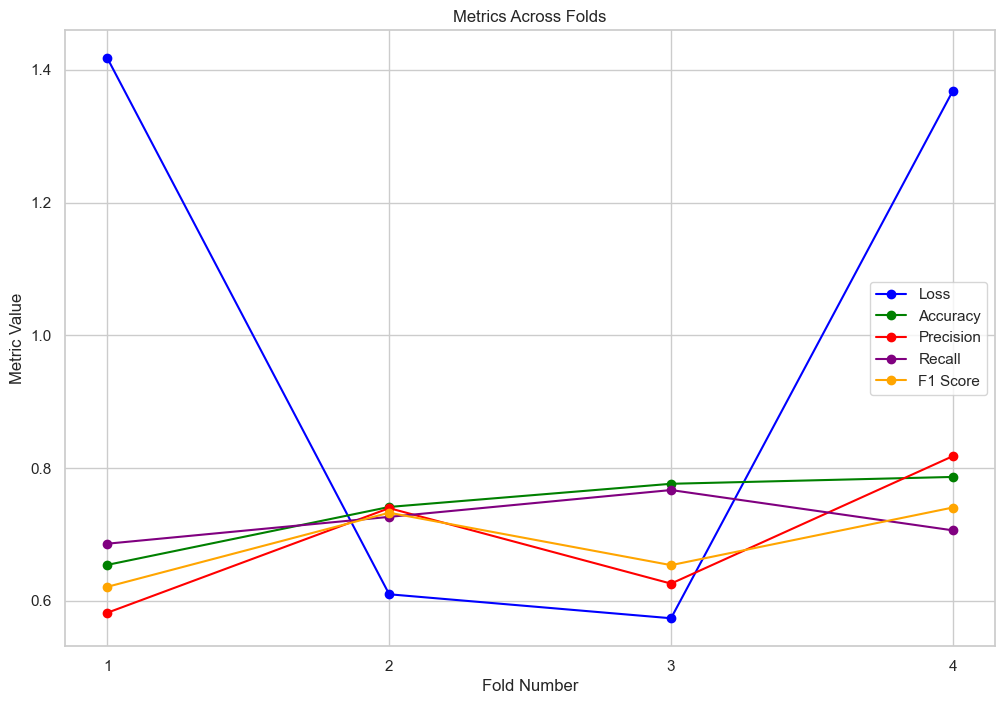

In [24]:
seed_1_folds_values = (unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1)

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [25]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 826, Predictions: 826, Actuals: 826, Gender: 826


In [26]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [27]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.78 (84/108)


In [28]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [29]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, adult, adult, adult, ad...",adult,adult,True
61,056A,"[senior, senior, senior]",senior,senior,True
76,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
75,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
74,069A,"[adult, adult]",adult,adult,True
73,068A,"[adult, adult, kitten, adult, senior, adult, a...",adult,adult,True
72,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,066A,[adult],adult,adult,True
69,064A,"[adult, adult, adult]",adult,adult,True
67,062A,"[adult, adult, adult, adult]",adult,adult,True


In [30]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     60
kitten    12
senior    12
Name: Majority_Correct, dtype: int64


In [31]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             60  82.191781
1           kitten           14             12  85.714286
2           senior           21             12  57.142857


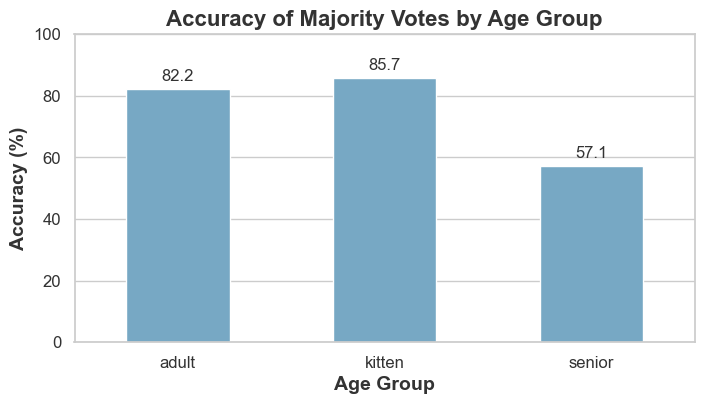

In [32]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [33]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          560            443  79.107143
1           kitten           95             72  75.789474
2           senior          171             92  53.801170


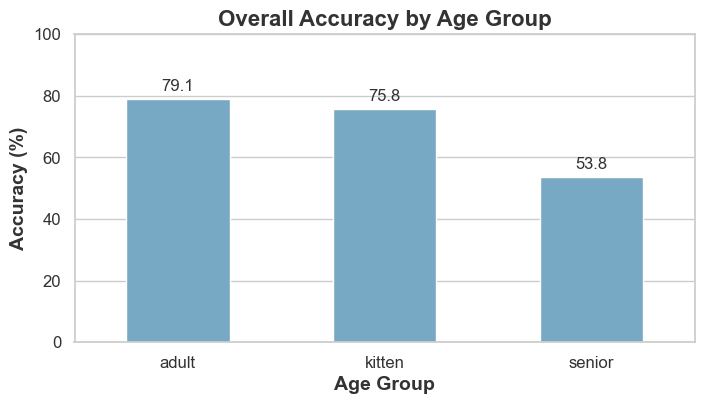

In [34]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [35]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    217      168     77.42
1          M    337      257     76.26
2          X    272      182     66.91


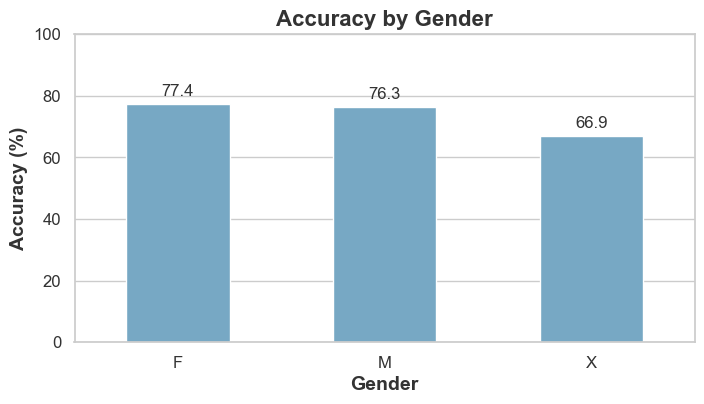

In [36]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [37]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7777777777777778]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          560            443  79.107143
1           kitten           95             72  75.789474
2           senior          171             92  53.801170]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    217      168     77.42
1          M    337      257     76.26
2          X    272      182     66.91]


# RANDOM SEED 2

In [38]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

# Filter out rows where cat_id is '117A' or '042A' from dataframe
dataframe = dataframe[~dataframe['cat_id'].isin(['117A', '042A'])]

# Filter out rows where cat_id is '117A' or '042A' from augmented_df
augmented_df = augmented_df[~augmented_df['cat_id'].isin(['117A', '042A'])]

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    171
kitten    157
Name: age_group, dtype: int64
adult     588
senior    513
kitten    471
Name: age_group, dtype: int64


In [39]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [40]:
tf.keras.backend.clear_session()

## Run Setup

In [41]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

# Append averages to total lists
all_f1.append(unseen_set_avg_f1)
all_losses.append(unseen_set_avg_loss)
all_accuracies.append(unseen_set_avg_acc)
all_precisions.append(unseen_set_avg_precision)
all_recalls.append(unseen_set_avg_recall)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1


Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
055A    20
067A    19
000B    19
029A    17
019A    17
097A    16
059A    14
106A    14
001A    14
028A    13
111A    13
051A    12
039A    12
116A    12
025A    11
063A    11
068A    11
040A    10
071A    10
051B     9
022A     9
065A     9
015A     9
033A     9
072A     9
013B     8
094A     8
010A     8
050A     7
031A     7
099A     7
027A     7
053A     6
037A     6
007A     6
108A     6
023A     6
023B     5
075A     5
025C     5
034A     5
044A     5
021A     5
105A     4
003A     4
009A     4
026A     4
052A     4
104A     4
062A     4
012A     3
060A     3
006A     3
113A     3
014A     3
056A     3
058A     3
011A     2
093A     2
038A     2
054A     2
102A     2
032A     2
069A     2
061A     2
090A     1
115A     1
019B     1
073A     1
048A     1
066A     1
026C     1
041A     1
092A     1
049A     1
043A     1
026B     1
Name: cat_id, dtype: int64
Testing

Moved to Training/Validation Set:
{'046A'}
Removed from Training/Validation Set:
{'047A'}
Moved to Test Set:
{'047A'}
Removed from Test Set
{'046A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '001A' '002A' '002B' '003A' '004A' '005A' '006A' '008A' '010A'
 '011A' '012A' '013B' '014A' '014B' '015A' '016A' '018A' '020A' '021A'
 '024A' '025A' '025B' '026B' '027A' '028A' '031A' '033A' '034A' '035A'
 '036A' '037A' '038A' '039A' '040A' '041A' '043A' '045A' '046A' '048A'
 '049A' '050A' '051B' '053A' '054A' '055A' '057A' '058A' '060A' '061A'
 '062A' '064A' '067A' '069A' '070A' '071A' '072A' '074A' '075A' '076A'
 '087A' '088A' '090A' '091A' '092A' '093A' '095A' '096A' '097A' '097B'
 '099A' '100A' '101A' '102A' '105A' '106A' '109A' '110A' '113A' '115A'
 '116A']
AFTER SWAP - Unique Test Group IDs:
['000B' '007A' '009A' '019A' '019B' '022A' '023A' '023B' '025C' '026A'
 '026C' '029A' '032A' '044A' '047A' '051A' '052A' '056A' '059A' '063A'
 '065A' '066A' '068A' '073A' '094A' '103A' '1

Majority Vote Accuracy for cat_id for this fold: 0.69 (20/29)
Before appending - Cat IDs: 138, Predictions: 138, Actuals: 138, Gender: 138
After appending - Cat IDs: 397, Predictions: 397, Actuals: 397, Gender: 397
Final Test Results - Loss: 0.899771511554718, Accuracy: 0.6679536700248718, Precision: 0.6598686905592276, Recall: 0.6838733286522594, F1 Score: 0.6608042379152231
Confusion Matrix:
 [[108   7  51]
 [  7  39   0]
 [ 21   0  26]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
103A    33
047A    28
000B    19
067A    19
019A    17
029A    17
097A    16
101A    15
059A    14
097B    14
111A    13
002A    13
039A    12
116A    12
051A    12
063A    11
068A    11
036A    11
005A    10
016A    10
040A    10
014B    10
022A     9
072A     9
065A     9
051B     9
045A     9
033A     9
010A     8
094A     8
095A     8
027A     7
099A     7
031A     7
108A     6
109A     6
008A     6
023A     6
007A     6
037A     6
034A     5
025C     5
044A     5
070A     5
023B   

Majority Vote Accuracy for cat_id for this fold: 0.79 (22/28)
Before appending - Cat IDs: 397, Predictions: 397, Actuals: 397, Gender: 397
After appending - Cat IDs: 644, Predictions: 644, Actuals: 644, Gender: 644
Final Test Results - Loss: 0.9648016095161438, Accuracy: 0.7044534683227539, Precision: 0.6859903381642513, Recall: 0.6709017889740782, F1 Score: 0.6531896824471717
Confusion Matrix:
 [[150   2  14]
 [  1  10   0]
 [ 56   0  14]]
outer_fold 4
Train Set Group Distribution:
046A    63
103A    33
002B    32
057A    27
074A    25
020A    23
055A    20
000B    19
029A    17
019A    17
101A    15
106A    14
097B    14
001A    14
059A    14
028A    13
111A    13
002A    13
051A    12
036A    11
025A    11
063A    11
068A    11
016A    10
014B    10
071A    10
005A    10
022A     9
015A     9
065A     9
045A     9
095A     8
013B     8
094A     8
050A     7
053A     6
007A     6
008A     6
023A     6
109A     6
108A     6
023B     5
075A     5
044A     5
070A     5
025C     5
026A  

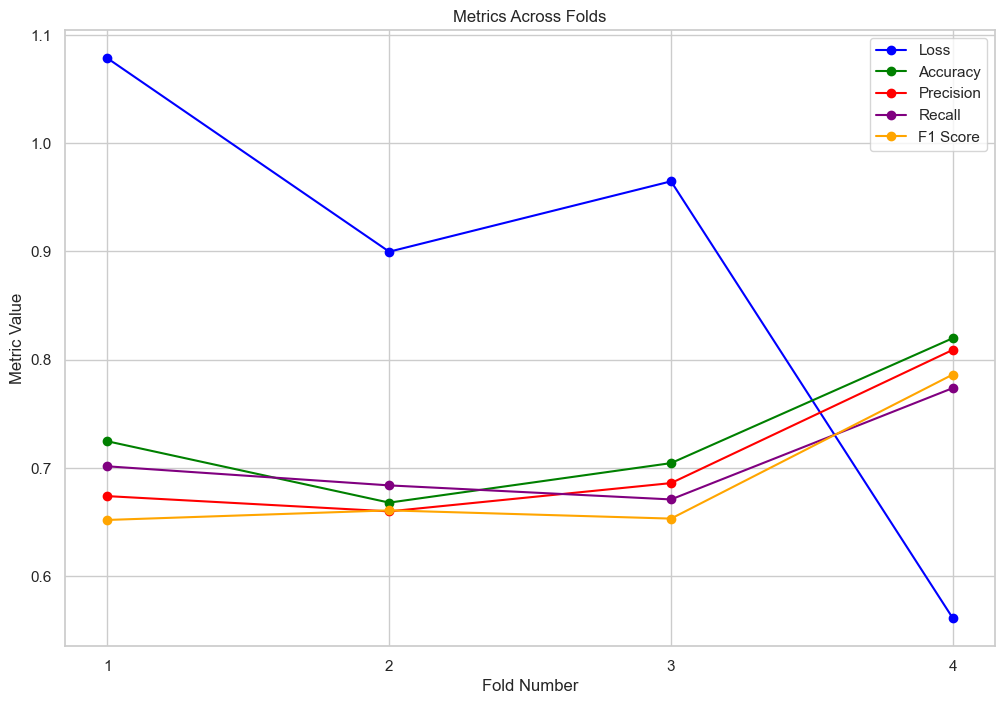

In [42]:
seed_2_folds_values = (unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1)

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [43]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 855, Predictions: 855, Actuals: 855, Gender: 855


In [44]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [45]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.75 (81/108)


In [46]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [47]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, kitten, senior, senior, adult,...",adult,adult,True
79,074A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
76,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
75,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
74,069A,"[adult, adult]",adult,adult,True
72,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
69,064A,"[adult, adult, adult]",adult,adult,True
68,063A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
67,062A,"[adult, adult, adult, adult]",adult,adult,True
64,059A,"[senior, adult, adult, adult, senior, senior, ...",senior,senior,True


In [48]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     58
kitten    12
senior    11
Name: Majority_Correct, dtype: int64


In [49]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             58  79.452055
1           kitten           14             12  85.714286
2           senior           21             11  52.380952


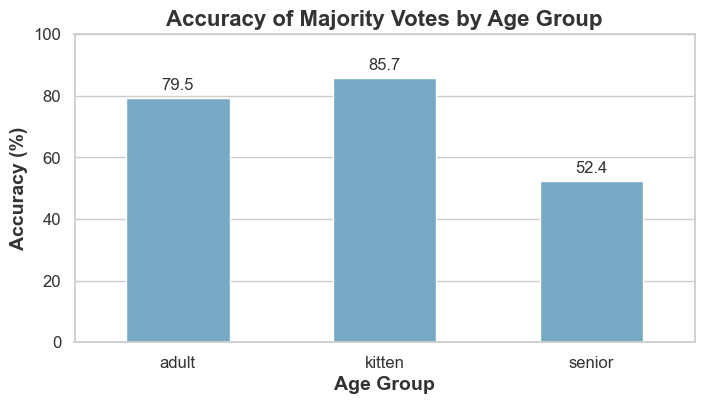

In [50]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [51]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          562            445  79.181495
1           kitten          122            105  86.065574
2           senior          171             70  40.935673


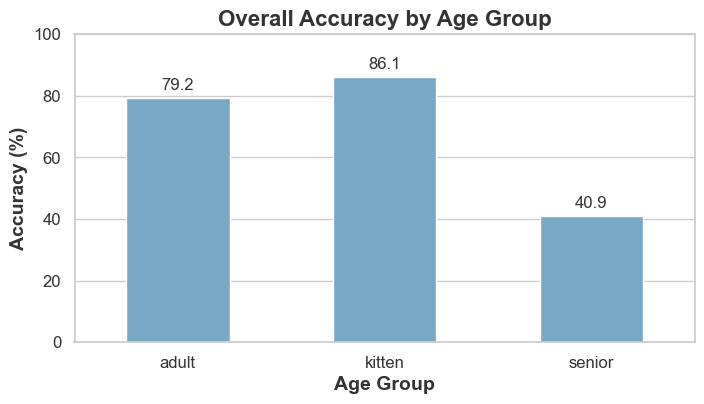

In [52]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [53]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    219      155     70.78
1          M    337      241     71.51
2          X    299      224     74.92


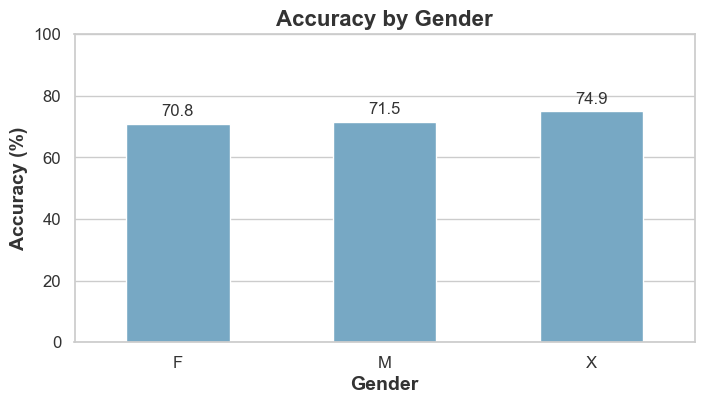

In [54]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [55]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7777777777777778, 0.75]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          560            443  79.107143
1           kitten           95             72  75.789474
2           senior          171             92  53.801170,   actual_age_group  total_count  correct_count   accuracy
0            adult          562            445  79.181495
1           kitten          122            105  86.065574
2           senior          171             70  40.935673]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    217      168     77.42
1          M    337      257     76.26
2          X    272      182     66.91,   all_gender  count  correct  accuracy
0          F    219      155     70.78
1          M    337      241     71.51
2          X    299      224     74.92]


# RANDOM SEED 3

In [56]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

# Filter out rows where cat_id is '117A' or '042A' from dataframe
dataframe = dataframe[~dataframe['cat_id'].isin(['117A', '042A'])]

# Filter out rows where cat_id is '117A' or '042A' from augmented_df
augmented_df = augmented_df[~augmented_df['cat_id'].isin(['117A', '042A'])]

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    171
kitten    157
Name: age_group, dtype: int64
adult     588
senior    513
kitten    471
Name: age_group, dtype: int64


In [57]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [58]:
tf.keras.backend.clear_session()

## Run Setup

In [59]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

# Append averages to total lists
all_f1.append(unseen_set_avg_f1)
all_losses.append(unseen_set_avg_loss)
all_accuracies.append(unseen_set_avg_acc)
all_precisions.append(unseen_set_avg_precision)
all_recalls.append(unseen_set_avg_recall)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
002B    32
047A    28
057A    27
074A    25
055A    20
000B    19
029A    17
097B    14
001A    14
111A    13
002A    13
051A    12
039A    12
025A    11
063A    11
068A    11
036A    11
005A    10
014B    10
040A    10
071A    10
022A     9
065A     9
045A     9
033A     9
051B     9
094A     8
013B     8
010A     8
095A     8
027A     7
099A     7
031A     7
008A     6
023A     6
007A     6
053A     6
109A     6
108A     6
021A     5
023B     5
034A     5
044A     5
025C     5
070A     5
035A     4
009A     4
026A     4
105A     4
052A     4
062A     4
003A     4
012A     3
064A     3
006A     3
058A     3
113A     3
032A     2
025B     2
102A     2
011A     2
038A     2
087A     2
061A     2
093A     2
018A     2
019B     1
110A     1
100A     1
115A     1
090A     1
024A     1
073A     1
048A     1
088A     1
004A     1
091A     1
076A     1
041A     1
092A     1
049A     1
096A     1
043A     1
026B     1
Name: cat_id, dtype: i

Majority Vote Accuracy for cat_id for this fold: 0.76 (19/25)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 247, Predictions: 247, Actuals: 247, Gender: 247
Final Test Results - Loss: 0.8288688659667969, Accuracy: 0.7246963381767273, Precision: 0.623667898868566, Recall: 0.7176334776334775, F1 Score: 0.6449060693641618
Confusion Matrix:
 [[139   7  19]
 [  1   6   0]
 [ 41   0  34]]
outer_fold 2
Train Set Group Distribution:
046A    63
000A    39
103A    33
047A    28
020A    23
055A    20
067A    19
029A    17
019A    17
097A    16
101A    15
059A    14
001A    14
097B    14
106A    14
111A    13
028A    13
039A    12
116A    12
051A    12
063A    11
036A    11
025A    11
068A    11
040A    10
071A    10
005A    10
016A    10
014B    10
051B     9
033A     9
015A     9
072A     9
045A     9
010A     8
094A     8
095A     8
050A     7
099A     7
109A     6
037A     6
007A     6
053A     6
108A     6
008A     6
025C     5
075A     5
023B

Epoch 1/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.9388 - accuracy: 0.5628
Epoch 2/1500
60/60 [==============================] - 0s 991us/step - loss: 0.6953 - accuracy: 0.6653
Epoch 3/1500
60/60 [==============================] - 0s 975us/step - loss: 0.6223 - accuracy: 0.6930
Epoch 4/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.5998 - accuracy: 0.7071
Epoch 5/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.5591 - accuracy: 0.7155
Epoch 6/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.5182 - accuracy: 0.7411
Epoch 7/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.5140 - accuracy: 0.7531
Epoch 8/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.4920 - accuracy: 0.7620
Epoch 9/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.7720
Epoch 10/1500
60/60 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.

Majority Vote Accuracy for cat_id for this fold: 0.75 (21/28)
Before appending - Cat IDs: 460, Predictions: 460, Actuals: 460, Gender: 460
After appending - Cat IDs: 652, Predictions: 652, Actuals: 652, Gender: 652
Final Test Results - Loss: 0.8353145718574524, Accuracy: 0.71875, Precision: 0.6587962962962962, Recall: 0.6970635408135407, F1 Score: 0.6630829952195396
Confusion Matrix:
 [[61  8 27]
 [10 64  0]
 [ 9  0 13]]
outer_fold 4
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
000B    19
019A    17
097A    16
101A    15
106A    14
059A    14
002A    13
028A    13
111A    13
116A    12
025A    11
068A    11
063A    11
016A    10
071A    10
040A    10
022A     9
033A     9
045A     9
015A     9
051B     9
065A     9
072A     9
094A     8
013B     8
095A     8
031A     7
050A     7
027A     7
099A     7
008A     6
007A     6
037A     6
109A     6
023A     6
053A     6
075A     5
044A     5
070A     5
034A

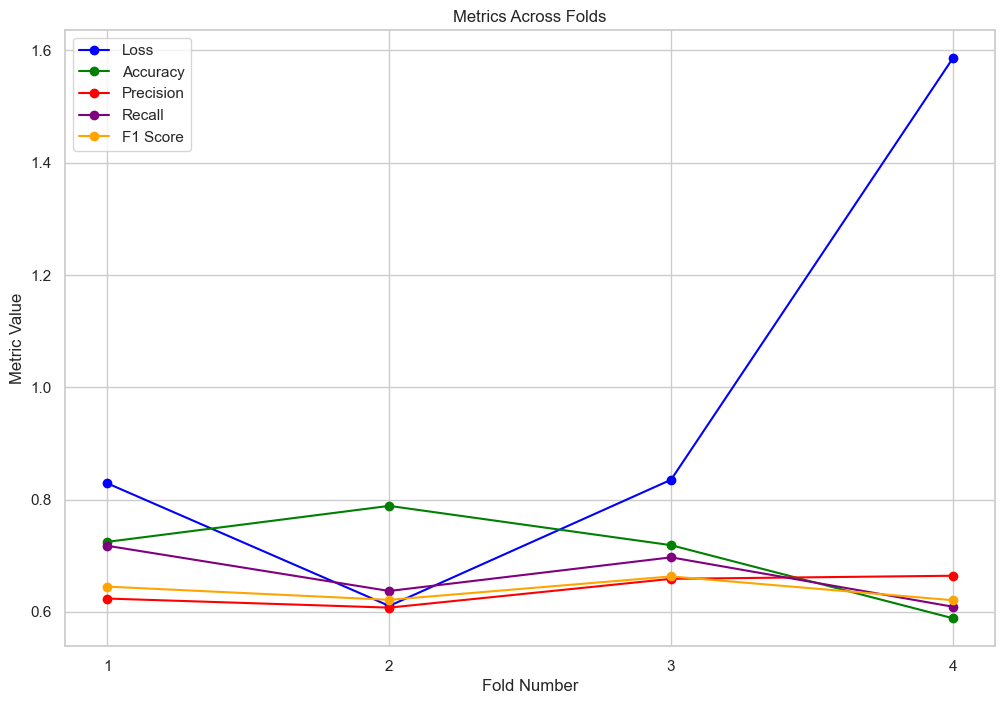

In [60]:
seed_3_folds_values = (unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1)

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [61]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 827, Predictions: 827, Actuals: 827, Gender: 827


In [62]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [63]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.73 (79/108)


In [64]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [65]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
60,055A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True
75,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
74,069A,"[adult, adult]",adult,adult,True
73,068A,"[adult, adult, adult, senior, senior, adult, a...",adult,adult,True
72,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,066A,[adult],adult,adult,True
70,065A,"[senior, adult, adult, adult, adult, senior, k...",adult,adult,True
69,064A,"[adult, adult, adult]",adult,adult,True
67,062A,"[adult, adult, adult, adult]",adult,adult,True


In [66]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     60
kitten    11
senior     8
Name: Majority_Correct, dtype: int64


In [67]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             60  82.191781
1           kitten           14             11  78.571429
2           senior           21              8  38.095238


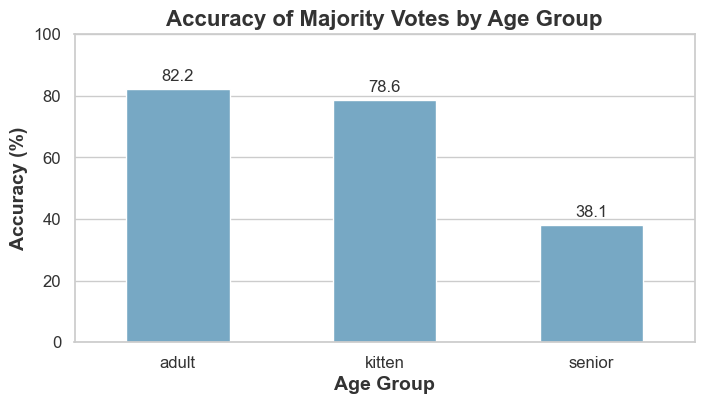

In [68]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [69]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          555            422  76.036036
1           kitten          101             84  83.168317
2           senior          171             82  47.953216


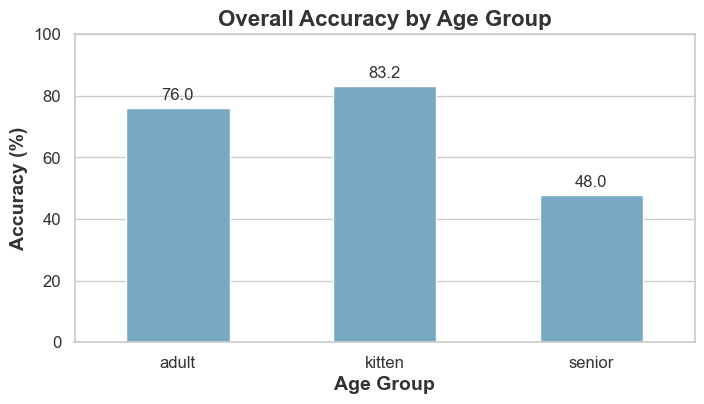

In [70]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [71]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    206      160     77.67
1          M    343      231     67.35
2          X    278      197     70.86


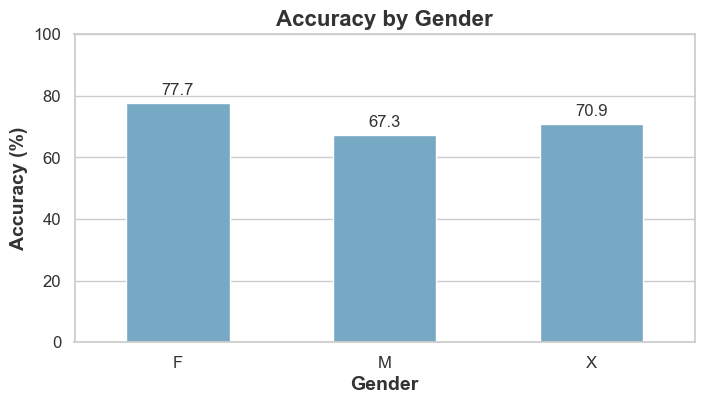

In [72]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [73]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7777777777777778, 0.75, 0.7314814814814815]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          560            443  79.107143
1           kitten           95             72  75.789474
2           senior          171             92  53.801170,   actual_age_group  total_count  correct_count   accuracy
0            adult          562            445  79.181495
1           kitten          122            105  86.065574
2           senior          171             70  40.935673,   actual_age_group  total_count  correct_count   accuracy
0            adult          555            422  76.036036
1           kitten          101             84  83.168317
2           senior          171             82  47.953216]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    217      168     77.42
1          M    337      257     76.26
2          X    272      182     66

# RANDOM SEED 4

In [74]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

# Filter out rows where cat_id is '117A' or '042A' from dataframe
dataframe = dataframe[~dataframe['cat_id'].isin(['117A', '042A'])]

# Filter out rows where cat_id is '117A' or '042A' from augmented_df
augmented_df = augmented_df[~augmented_df['cat_id'].isin(['117A', '042A'])]

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    171
kitten    157
Name: age_group, dtype: int64
adult     588
senior    513
kitten    471
Name: age_group, dtype: int64


In [75]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [76]:
tf.keras.backend.clear_session()

## Run Setup

In [77]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

# Append averages to total lists
all_f1.append(unseen_set_avg_f1)
all_losses.append(unseen_set_avg_loss)
all_accuracies.append(unseen_set_avg_acc)
all_precisions.append(unseen_set_avg_precision)
all_recalls.append(unseen_set_avg_recall)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
057A    27
074A    25
020A    23
055A    20
000B    19
029A    17
019A    17
097A    16
101A    15
001A    14
059A    14
097B    14
028A    13
111A    13
002A    13
039A    12
051A    12
025A    11
036A    11
068A    11
063A    11
014B    10
040A    10
016A    10
071A    10
051B     9
065A     9
045A     9
010A     8
094A     8
095A     8
013B     8
031A     7
027A     7
053A     6
023A     6
108A     6
007A     6
037A     6
023B     5
044A     5
034A     5
021A     5
070A     5
025C     5
075A     5
003A     4
026A     4
104A     4
035A     4
058A     3
060A     3
012A     3
006A     3
056A     3
113A     3
087A     2
093A     2
025B     2
054A     2
032A     2
069A     2
038A     2
061A     2
088A     1
024A     1
090A     1
110A     1
115A     1
019B     1
073A     1
004A     1
048A     1
043A     1
026C     1
041A     1
092A     1
049A     1
076A     1
096A     1
026B     1
Name: cat_id, dtype: i

Majority Vote Accuracy for cat_id for this fold: 0.80 (20/25)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 176, Predictions: 176, Actuals: 176, Gender: 176
Final Test Results - Loss: 0.8305748105049133, Accuracy: 0.7443181872367859, Precision: 0.6804778554778554, Recall: 0.671513237161744, F1 Score: 0.6757315431150556
Confusion Matrix:
 [[86  5 16]
 [ 6 35  0]
 [18  0 10]]
outer_fold 2
Train Set Group Distribution:
000A    39
103A    33
002B    32
047A    28
074A    25
020A    23
067A    19
019A    17
097A    16
106A    14
001A    14
059A    14
028A    13
111A    13
002A    13
039A    12
116A    12
051A    12
036A    11
068A    11
025A    11
071A    10
014B    10
040A    10
005A    10
016A    10
051B     9
045A     9
015A     9
033A     9
065A     9
072A     9
022A     9
094A     8
095A     8
050A     7
031A     7
099A     7
027A     7
008A     6
109A     6
007A     6
037A     6
023B     5
021A     5
034A     5
075A     5
009A     4
10

Age group distribution: Counter({0: 756, 2: 572, 1: 544})
Epoch 1/1500
59/59 [==============================] - 0s 1ms/step - loss: 1.0869 - accuracy: 0.5337
Epoch 2/1500
59/59 [==============================] - 0s 1ms/step - loss: 0.7275 - accuracy: 0.6880
Epoch 3/1500
59/59 [==============================] - 0s 1ms/step - loss: 0.6850 - accuracy: 0.7051
Epoch 4/1500
59/59 [==============================] - 0s 1ms/step - loss: 0.6127 - accuracy: 0.7425
Epoch 5/1500
59/59 [==============================] - 0s 1ms/step - loss: 0.5990 - accuracy: 0.7505
Epoch 6/1500
59/59 [==============================] - 0s 1ms/step - loss: 0.5491 - accuracy: 0.7660
Epoch 7/1500
59/59 [==============================] - 0s 981us/step - loss: 0.5295 - accuracy: 0.7815
Epoch 8/1500
59/59 [==============================] - 0s 971us/step - loss: 0.5328 - accuracy: 0.7698
Epoch 9/1500
59/59 [==============================] - 0s 995us/step - loss: 0.4917 - accuracy: 0.7981
Epoch 10/1500
59/59 [===============

Epoch 1/1500
61/61 [==============================] - 0s 1ms/step - loss: 0.9462 - accuracy: 0.5491
Epoch 2/1500
61/61 [==============================] - 0s 1ms/step - loss: 0.7629 - accuracy: 0.6319
Epoch 3/1500
61/61 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.6686
Epoch 4/1500
61/61 [==============================] - 0s 1ms/step - loss: 0.6623 - accuracy: 0.6934
Epoch 5/1500
61/61 [==============================] - 0s 999us/step - loss: 0.6073 - accuracy: 0.7048
Epoch 6/1500
61/61 [==============================] - 0s 993us/step - loss: 0.5653 - accuracy: 0.7316
Epoch 7/1500
61/61 [==============================] - 0s 1ms/step - loss: 0.5597 - accuracy: 0.7342
Epoch 8/1500
61/61 [==============================] - 0s 975us/step - loss: 0.5187 - accuracy: 0.7503
Epoch 9/1500
61/61 [==============================] - 0s 948us/step - loss: 0.5186 - accuracy: 0.7622
Epoch 10/1500
61/61 [==============================] - 0s 950us/step - loss: 0.5082 - accura

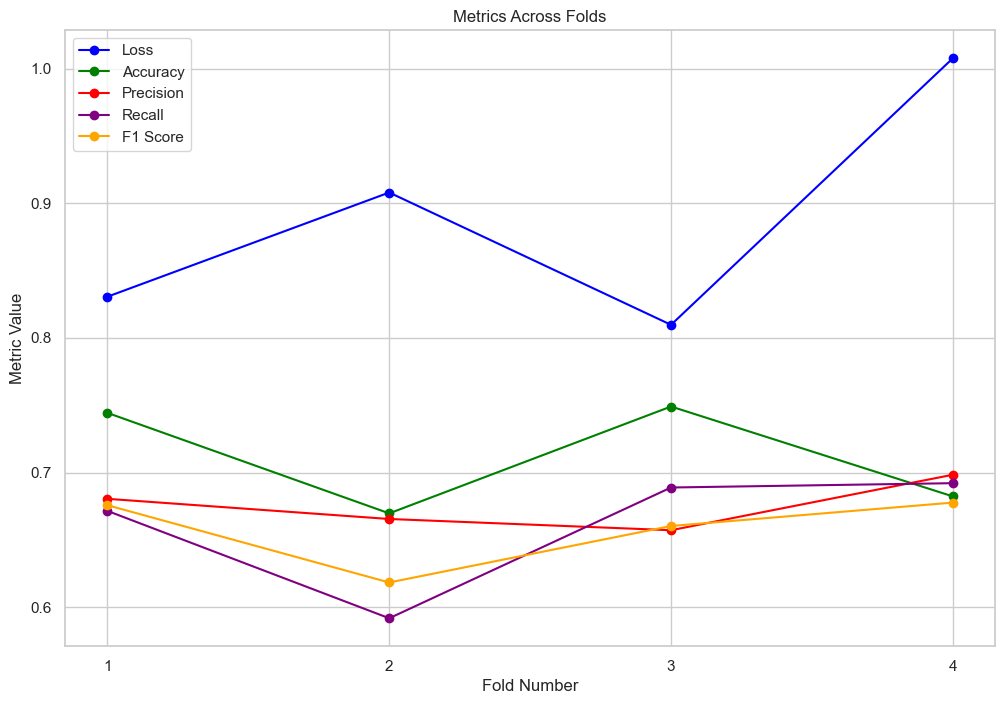

In [78]:
seed_4_folds_values = (unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1)

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [79]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 848, Predictions: 848, Actuals: 848, Gender: 848


In [80]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [81]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.75 (81/108)


In [82]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [83]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, kitten, kitten, adult, adult, a...",adult,adult,True
77,072A,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
75,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,069A,"[adult, adult]",adult,adult,True
73,068A,"[adult, adult, adult, senior, senior, adult, a...",adult,adult,True
72,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,066A,[adult],adult,adult,True
70,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True
69,064A,"[adult, adult, adult]",adult,adult,True
68,063A,"[senior, senior, senior, adult, adult, senior,...",adult,adult,True


In [84]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     61
kitten    12
senior     8
Name: Majority_Correct, dtype: int64


In [85]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             61  83.561644
1           kitten           14             12  85.714286
2           senior           21              8  38.095238


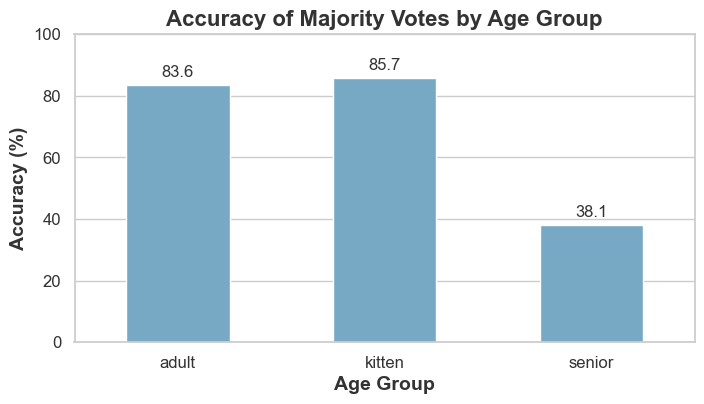

In [86]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [87]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          555            443  79.819820
1           kitten          122             93  76.229508
2           senior          171             68  39.766082


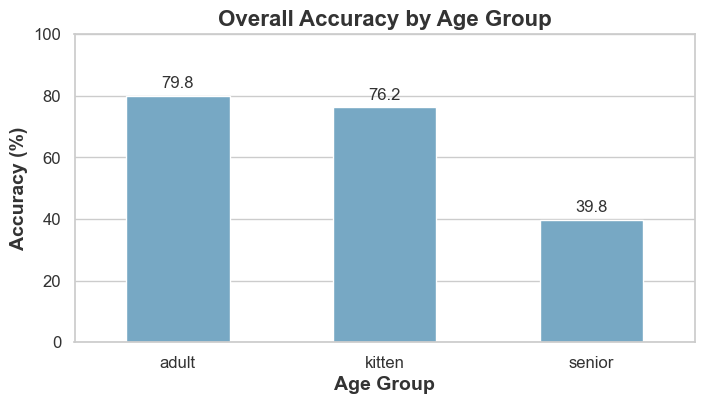

In [88]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [89]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    212      163     76.89
1          M    337      236     70.03
2          X    299      205     68.56


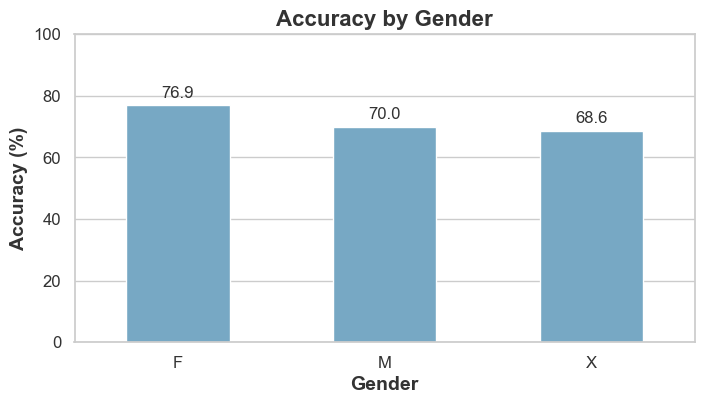

In [90]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [91]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7777777777777778, 0.75, 0.7314814814814815, 0.75]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          560            443  79.107143
1           kitten           95             72  75.789474
2           senior          171             92  53.801170,   actual_age_group  total_count  correct_count   accuracy
0            adult          562            445  79.181495
1           kitten          122            105  86.065574
2           senior          171             70  40.935673,   actual_age_group  total_count  correct_count   accuracy
0            adult          555            422  76.036036
1           kitten          101             84  83.168317
2           senior          171             82  47.953216,   actual_age_group  total_count  correct_count   accuracy
0            adult          555            443  79.819820
1           kitten          122             93  76.229508
2   

# RANDOM SEED 5

In [92]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/8april_looped_embeddings.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/audioset-thesis-work/audioset/vggish/embeddings/augmented_dataset_19.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

# Filter out rows where cat_id is '117A' or '042A' from dataframe
dataframe = dataframe[~dataframe['cat_id'].isin(['117A', '042A'])]

# Filter out rows where cat_id is '117A' or '042A' from augmented_df
augmented_df = augmented_df[~augmented_df['cat_id'].isin(['117A', '042A'])]

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     588
senior    171
kitten    157
Name: age_group, dtype: int64
adult     588
senior    513
kitten    471
Name: age_group, dtype: int64


In [93]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [94]:
tf.keras.backend.clear_session()

## Run Setup

In [95]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00038188800331973483)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27188281261238406))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping], class_weight=weight_dict)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

# Append averages to total lists
all_f1.append(unseen_set_avg_f1)
all_losses.append(unseen_set_avg_loss)
all_accuracies.append(unseen_set_avg_acc)
all_precisions.append(unseen_set_avg_precision)
all_recalls.append(unseen_set_avg_recall)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)
    


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
074A    25
000B    19
019A    17
097A    16
101A    15
097B    14
059A    14
002A    13
028A    13
051A    12
039A    12
116A    12
025A    11
068A    11
036A    11
063A    11
014B    10
071A    10
005A    10
065A     9
022A     9
051B     9
033A     9
095A     8
010A     8
094A     8
013B     8
027A     7
099A     7
050A     7
031A     7
008A     6
023A     6
037A     6
108A     6
034A     5
075A     5
023B     5
021A     5
070A     5
035A     4
009A     4
052A     4
104A     4
003A     4
026A     4
062A     4
113A     3
056A     3
014A     3
058A     3
064A     3
060A     3
102A     2
011A     2
038A     2
025B     2
061A     2
093A     2
054A     2
087A     2
069A     2
018A     2
032A     2
100A     1
115A     1
024A     1
019B     1
090A     1
096A     1
088A     1
066A     1
026C     1
041A     1
092A     1
049A     1
073A     1
076A     1
091A     1
026B     1
Name: cat_id, dtype: i

Moved to Training/Validation Set:
{'000A'}
Removed from Training/Validation Set:
{'067A'}
Moved to Test Set:
{'067A'}
Removed from Test Set
{'000A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '001A' '002B' '003A' '004A' '005A' '006A' '007A' '008A' '009A'
 '012A' '013B' '014A' '014B' '015A' '016A' '019A' '020A' '022A' '023A'
 '023B' '024A' '025B' '025C' '026C' '027A' '028A' '029A' '032A' '034A'
 '035A' '036A' '039A' '040A' '041A' '043A' '044A' '045A' '046A' '047A'
 '048A' '049A' '050A' '051A' '052A' '053A' '054A' '055A' '056A' '057A'
 '058A' '059A' '060A' '061A' '063A' '066A' '069A' '070A' '071A' '072A'
 '073A' '074A' '075A' '076A' '090A' '092A' '096A' '097A' '097B' '099A'
 '100A' '103A' '105A' '106A' '108A' '109A' '110A' '111A' '113A' '115A'
 '116A']
AFTER SWAP - Unique Test Group IDs:
['000B' '002A' '010A' '011A' '018A' '019B' '021A' '025A' '026A' '026B'
 '031A' '033A' '037A' '038A' '051B' '062A' '064A' '065A' '067A' '068A'
 '087A' '088A' '091A' '093A' '094A' '095A' '1

/Users/astrid/miniforge3/envs/april2-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 000A, 033A, 015A, 001A, 103A, 097B, 028...
kitten    [044A, 014B, 111A, 040A, 109A, 050A, 043A, 045...
senior    [093A, 057A, 106A, 104A, 055A, 051B, 056A, 051...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
adult     [071A, 074A, 022A, 034A, 005A, 023A, 063A, 099...
kitten                       [046A, 047A, 049A, 041A, 115A]
senior           [097A, 059A, 113A, 116A, 054A, 090A, 024A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'adult': 58, 'kitten': 10, 'senior': 14}
Count of Unique Cat IDs per Age Group in Testing Set:
{'adult': 16, 'kitten': 5, 'senior': 7}
Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '002B' '004A' '006A' '007A' '008A' '009A'
 '010A' '011A' '012A' '013B' '014A' '014B' '015A' '016A' '018A' '019A'
 '019B' '020A' '021A' '025A' '025B' '025C' '026A' '026B' '027A' '028A'
 '029A' '

Train Age Group Distribution AFTER SWAP:
adult     418
senior    145
kitten    140
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     170
senior     26
kitten     17
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 836, 2: 580, 1: 560})
Epoch 1/1500
62/62 [==============================] - 0s 1ms/step - loss: 0.9486 - accuracy: 0.5658
Epoch 2/1500
62/62 [==============================] - 0s 967us/step - loss: 0.7272 - accuracy: 0.6473
Epoch 3/1500
62/62 [==============================] - 0s 965us/step - loss: 0.6567 - accuracy: 0.7009
Epoch 4/1500
62/62 [==============================] - 0s 992us/step - loss: 0.6080 - accuracy: 0.7303
Epoch 5/1500
62/62 [==============================] - 0s 964us/step - loss: 0.5534 - accuracy: 0.7601
Epoch 6/1500
62/62 [==============================] - 0s 979us/step - loss: 0.5525 - accuracy: 0.7520
Epoch 7/1500
62/62 [==============================] - 0s 963

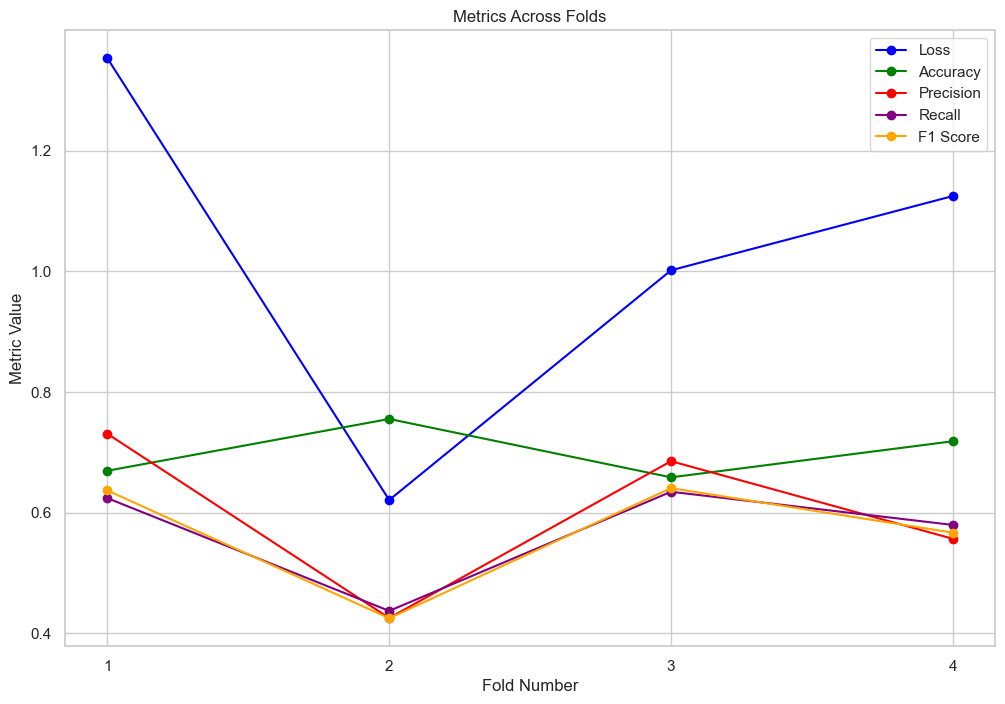

In [96]:
seed_5_folds_values = (unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1)

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [97]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 842, Predictions: 842, Actuals: 842, Gender: 842


In [98]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [99]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.74 (80/108)


In [100]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [101]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, kitten, adult, senior, adult, adult, a...",adult,adult,True
61,056A,"[senior, senior, senior]",senior,senior,True
75,070A,"[adult, adult, adult, adult, senior]",adult,adult,True
74,069A,"[adult, adult]",adult,adult,True
72,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,066A,[adult],adult,adult,True
70,065A,"[senior, adult, adult, adult, kitten, senior, ...",adult,adult,True
69,064A,"[adult, adult, adult]",adult,adult,True
67,062A,"[adult, adult, adult, adult]",adult,adult,True
64,059A,"[senior, adult, adult, adult, senior, senior, ...",senior,senior,True


In [102]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     62
kitten    10
senior     8
Name: Majority_Correct, dtype: int64


In [103]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             62  84.931507
1           kitten           14             10  71.428571
2           senior           21              8  38.095238


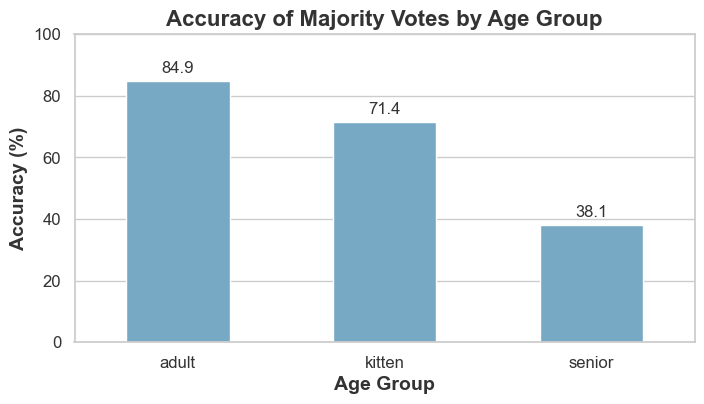

In [104]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [105]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          568            453  79.753521
1           kitten          103             68  66.019417
2           senior          171             67  39.181287


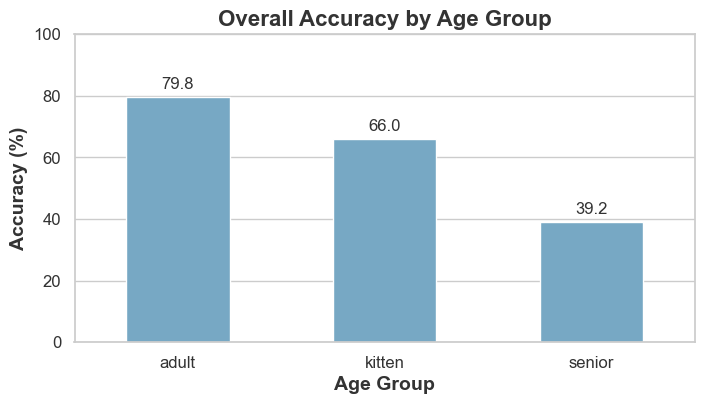

In [106]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [107]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    206      148     71.84
1          M    356      270     75.84
2          X    280      170     60.71


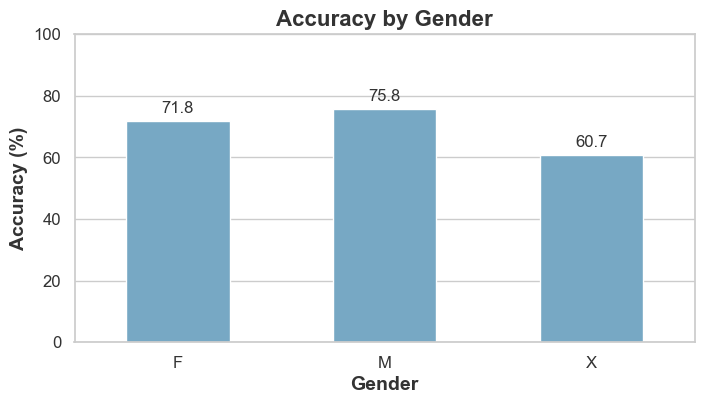

In [108]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [109]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7777777777777778, 0.75, 0.7314814814814815, 0.75, 0.7407407407407407]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          560            443  79.107143
1           kitten           95             72  75.789474
2           senior          171             92  53.801170,   actual_age_group  total_count  correct_count   accuracy
0            adult          562            445  79.181495
1           kitten          122            105  86.065574
2           senior          171             70  40.935673,   actual_age_group  total_count  correct_count   accuracy
0            adult          555            422  76.036036
1           kitten          101             84  83.168317
2           senior          171             82  47.953216,   actual_age_group  total_count  correct_count   accuracy
0            adult          555            443  79.819820
1           kitten          122           

# --------------

# Total Final Results & Analysis

In [110]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     74
kitten    15
senior    21
Name: cat_id, dtype: int64


## Metrics

In [111]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 0.949540427327156
Accuracy: 0.7171347320079804
Precision: 0.6623888626700758
Recall: 0.6647908202626495
F1 Score: 0.6475591196608269


## Majority Votes

In [112]:
# Average of majority vote accuracies
average_majority_vote_accuracy = np.mean(all_majority_vote_accuracies)
print("Average Majority Vote Accuracy:", average_majority_vote_accuracy)

Average Majority Vote Accuracy: 0.75


In [113]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_majority_vote_details = pd.concat(all_majority_vote_details)
average_majority_vote_details = total_majority_vote_details.groupby('actual_age_group').agg({
    'total_count': 'sum', 
    'correct_count': 'sum' 
}).reset_index()
average_majority_vote_details['accuracy'] = (average_majority_vote_details['correct_count'] / average_majority_vote_details['total_count']) * 100

print("Average Class Statistics:")
print(average_majority_vote_details)

Average Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          365            301  82.465753
1           kitten           70             57  81.428571
2           senior          105             47  44.761905


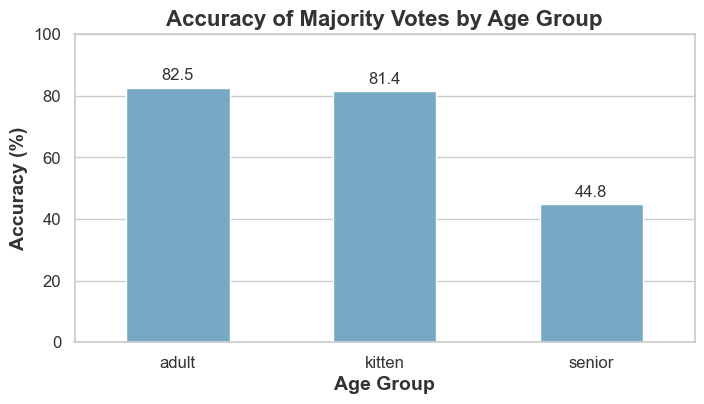

In [114]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(average_majority_vote_details, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [115]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_class_stats = pd.concat(all_class_stats)
average_class_stats = total_class_stats.groupby('actual_age_group').agg({
    'total_count': 'sum',  
    'correct_count': 'sum' 
}).reset_index()
average_class_stats['accuracy'] = (average_class_stats['correct_count'] / average_class_stats['total_count']) * 100

print("Average Class Statistics:")
print(average_class_stats)

Average Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult         2800           2206  78.785714
1           kitten          543            422  77.716390
2           senior          855            379  44.327485


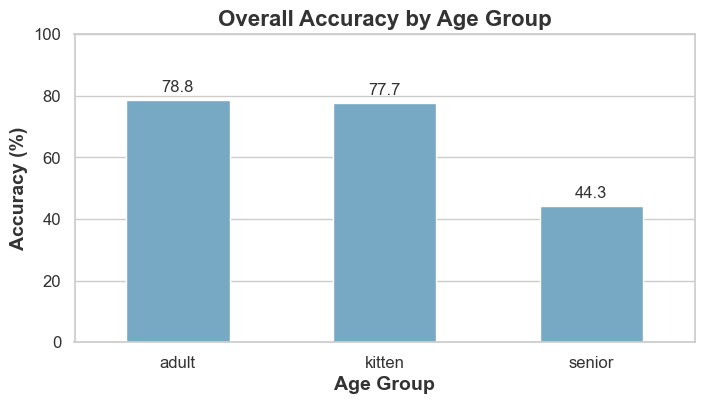

In [116]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(average_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

In [117]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F   1060      794  74.905660
1          M   1710     1235  72.222222
2          X   1428      978  68.487395


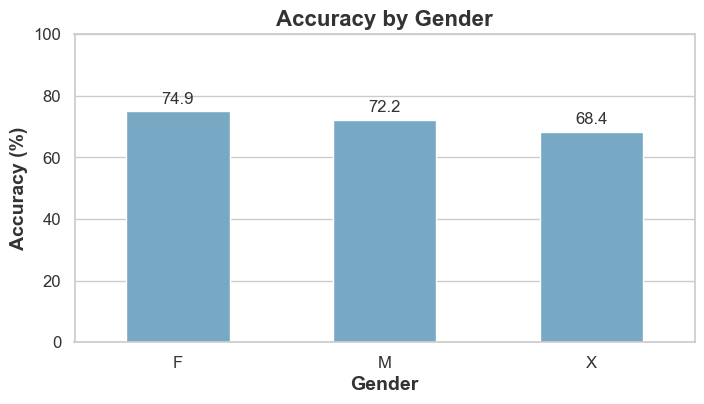

In [118]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

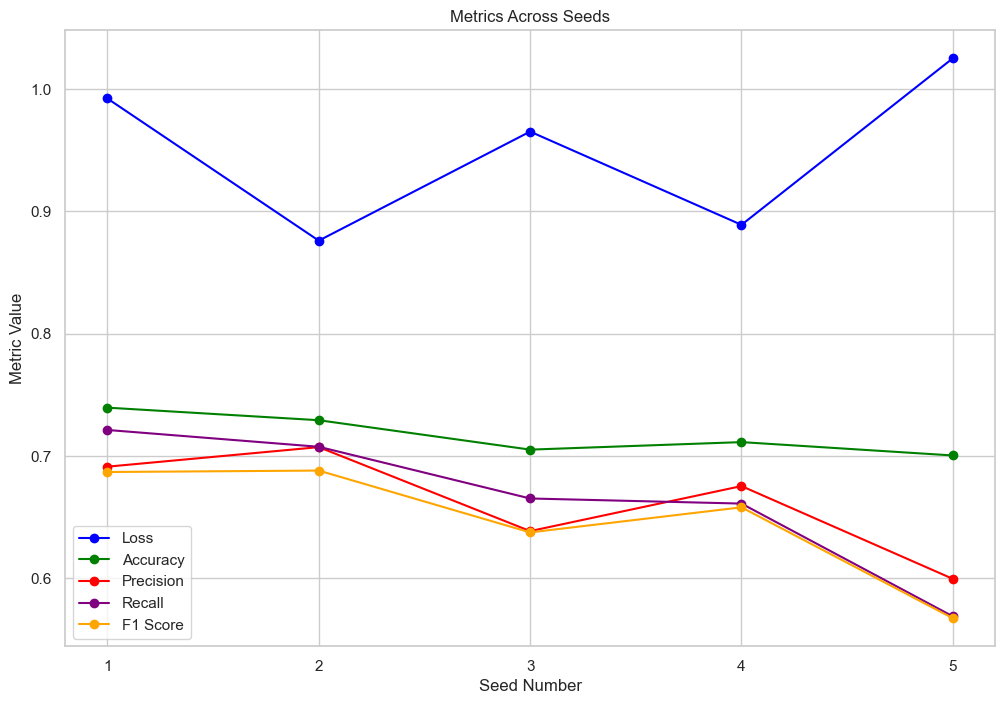

In [119]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(all_losses, all_accuracies, all_precisions, all_recalls, all_f1, "Seeds", "Seed Number")

In [120]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.058072196678028085
Accuracy: 0.01485103777958493
Precision: 0.03881379421812098
Recall: 0.0533504899524891
F1 Score: 0.044353072927456806


In [121]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 0.10329858958721161
Accuracy: 0.024049967527389526
Precision: 0.05267695714212539
Recall: 0.04644334142059425
F1 Score: 0.04937380207727338


## Display the seed folds results together

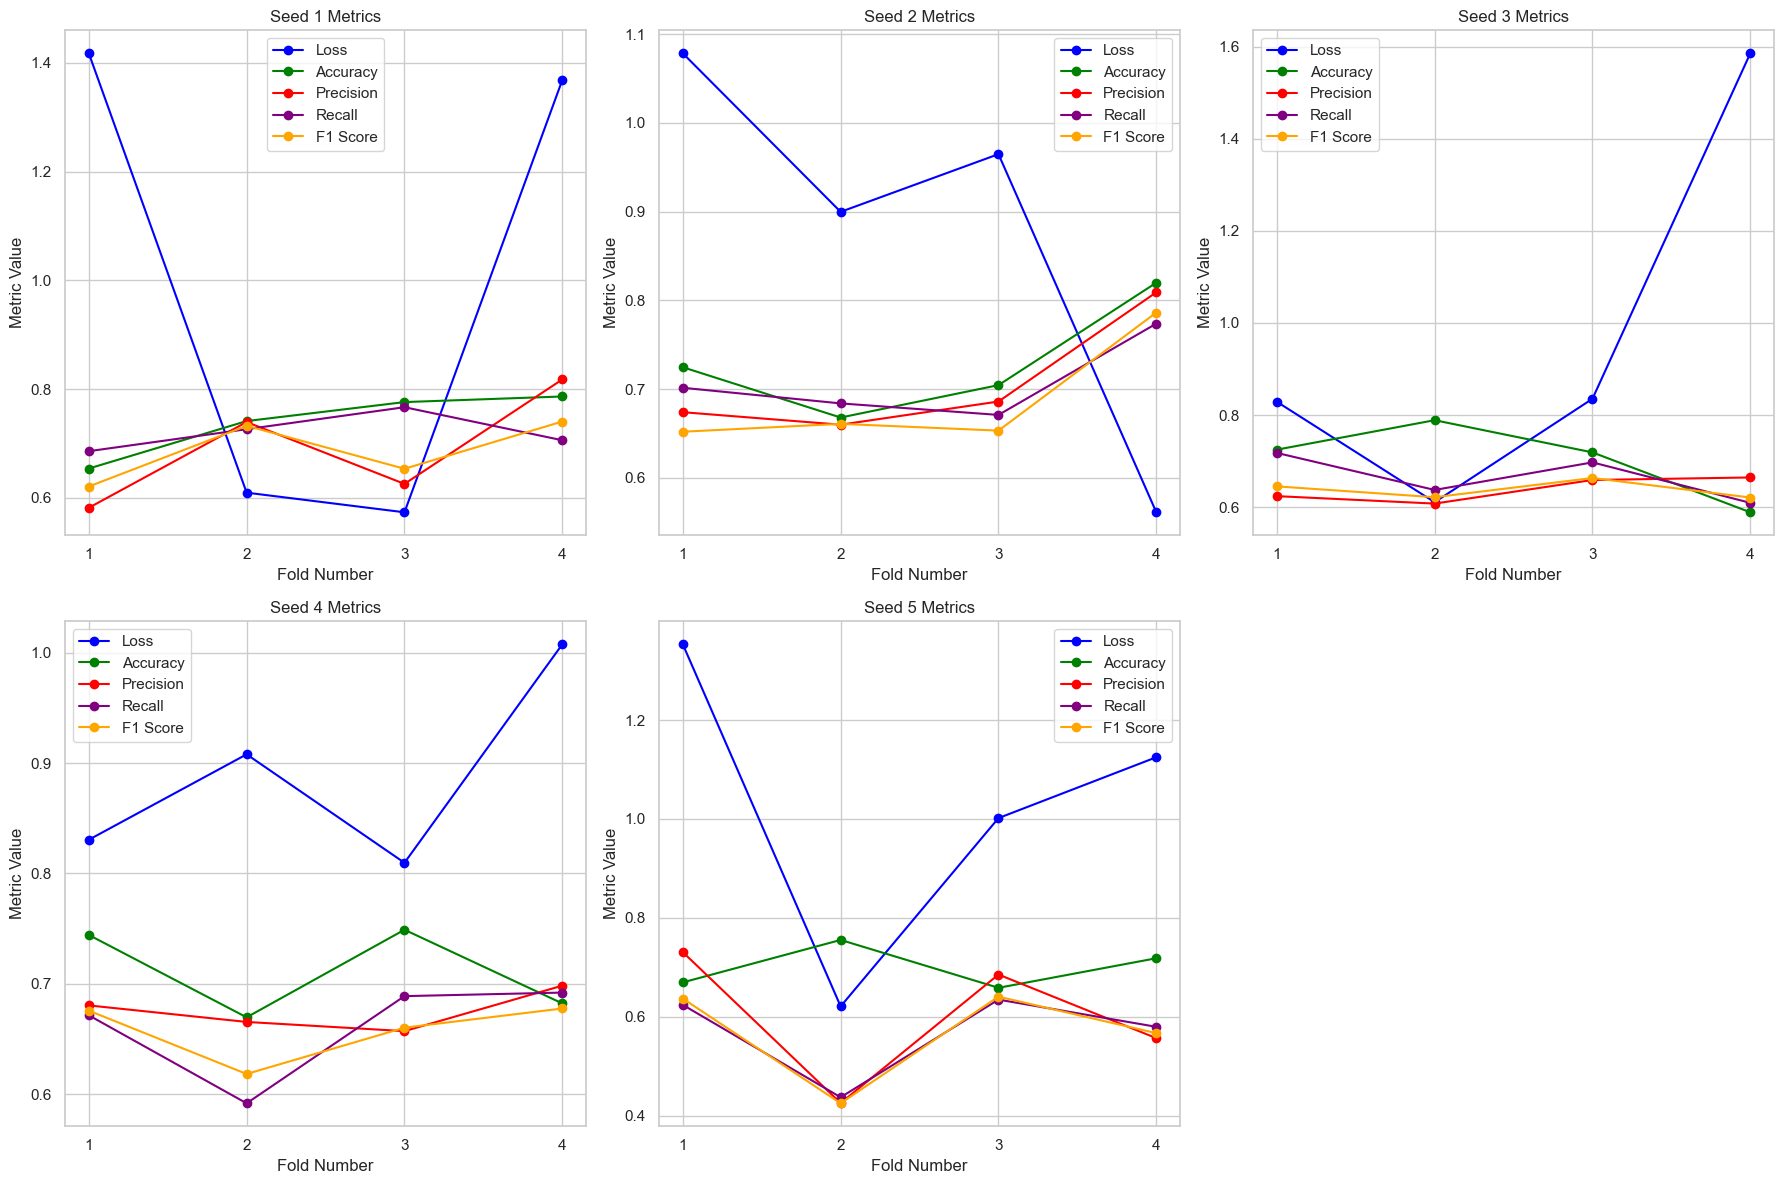

In [122]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()